In [1]:
import warnings
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from tensorflow.python.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.python.keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from joblib import dump, load

seed = 1
# # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("clean_train.csv")

df.head()

,ADDRESS,OPCODE,CATEGORY
0,0x219f4ee903f78e78773e5d1e3520cfd507485bc6,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
1,0x560ed796aa8d23411b94b9d047ecdda39d4fcdeb,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
2,0xe726f97ff3c63dd71c1520c102adc39d1a2693ea,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
3,0x8ebac490495958b3804bb079e259340f0f53b69c,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
4,0x190700d69031db6b072a30577f9b3dbc53a320a1,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0


In [3]:
df_temp = df
df_temp.loc[df_temp['CATEGORY'] == '1 0 0 0', 'LABEL_BIN'] = "Normal"
df_temp.loc[df_temp['CATEGORY'] != '1 0 0 0', 'LABEL_BIN'] = "Vulnerable"

In [4]:
pd.value_counts(df_temp['LABEL_BIN'])

Normal        884273
Vulnerable      8640
Name: LABEL_BIN, dtype: int64

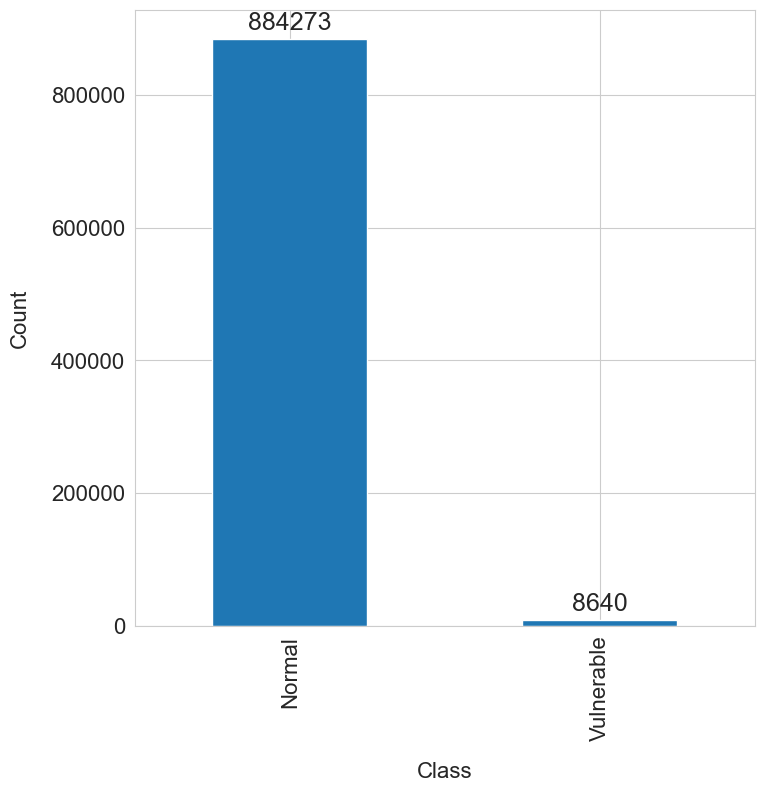

In [5]:
import seaborn as sns

sns.set_style("whitegrid")
font_size = 16
fig = plt.figure()
count_classes = pd.value_counts(df_temp['LABEL_BIN'], sort=True).sort_index()
count_classes.plot(kind='bar')
ax = plt.gca()
for bars in ax.containers:
    ax.bar_label(bars, padding=3, fontsize=18)
# plt.title("Vulnerability Class Histogram")
plt.xlabel("Class", fontsize=font_size, labelpad=15)
plt.ylabel("Count", fontsize=font_size, labelpad=15)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
fig.set_size_inches(8, 8)
plt.savefig('outputs_2/vulnerability_class_2.pdf', bbox_inches='tight')
plt.show()

In [6]:
def label(df):
    # label data
    df['LABEL_BIN'] = 0
    df['LABEL_MC'] = 0
    df.loc[df['CATEGORY'] == '1 0 0 0', 'LABEL_BIN'] = 0
    df.loc[df['CATEGORY'] != '1 0 0 0', 'LABEL_BIN'] = 1

    df.loc[df['CATEGORY'] == '1 0 0 0', 'LABEL_MC'] = 0
    df.loc[df['CATEGORY'] == '0 1 0 0', 'LABEL_MC'] = 1
    df.loc[df['CATEGORY'] == '0 0 1 0', 'LABEL_MC'] = 2
    df.loc[df['CATEGORY'] == '0 0 0 1', 'LABEL_MC'] = 3
    df.loc[df['CATEGORY'] == '0 1 1 0', 'LABEL_MC'] = 4


def preprocess(df):
    n_most_common_words = 1600
    max_len = 100  #contact length

    # Class Tokenizer - This class allows to vectorize a text corpus, by turning each text into either
    # a sequence of integers (each integer being the index of a token in a dictionary)
    tokenizer = Tokenizer(num_words=n_most_common_words, lower=False)

    # tokenizer.fit_on_texts(increased_vul['OPCODE'].values)
    tokenizer.fit_on_texts(df['OPCODE'].values)

    # # Transforms each text in texts in a sequence of integers.
    sequences = tokenizer.texts_to_sequences(df['OPCODE'].values)

    #Find number of unique words/tokens
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    #pad sequences with zeros in front to make them all maxlen
    X = pad_sequences(sequences, maxlen=max_len)
    return X


def dftoXY(df):
    # Save test X and y
    X_test = preprocess(df)
    # label data
    label(df)
    print(pd.value_counts(df['LABEL_BIN']))
    y_test = to_categorical(df['LABEL_BIN'], num_classes=5)
    return X_test, y_test


def XandY(posdf, negdf):
    dfset = pd.concat([posdf, negdf])
    dfset = dfset.sample(frac=1, random_state=39, replace=False)

    dfset['LABEL_BIN'] = 0
    dfset['LABEL_MC'] = 0

    #One-hot encode the lab
    dfset.loc[dfset['CATEGORY'] == '1 0 0 0', 'LABEL_BIN'] = 0
    dfset.loc[dfset['CATEGORY'] != '1 0 0 0', 'LABEL_BIN'] = 1

    dfset.loc[dfset['CATEGORY'] == '1 0 0 0', 'LABEL_MC'] = 0
    dfset.loc[dfset['CATEGORY'] == '0 1 0 0', 'LABEL_MC'] = 1
    dfset.loc[dfset['CATEGORY'] == '0 0 1 0', 'LABEL_MC'] = 2
    dfset.loc[dfset['CATEGORY'] == '0 0 0 1', 'LABEL_MC'] = 3
    dfset.loc[dfset['CATEGORY'] == '0 1 1 0', 'LABEL_MC'] = 4

    # df_train.head()

    X, y = dftoXY(dfset)

    print('Shape of X: {}'.format(X.shape))

    # for sm.fit_sample
    y_labels = np.expand_dims(np.array(np.argmax(y, axis=1)), axis=1)
    print('Shape of y: {}'.format(y_labels.shape))

    return X, y_labels

In [7]:
shuffled = df

n = shuffled[shuffled['CATEGORY'] == '1 0 0 0']  # no vulnerabilities
s = shuffled[shuffled['CATEGORY'] == '0 1 0 0']  # suicidal
p = shuffled[shuffled['CATEGORY'] == '0 0 1 0']  # prodigal
g = shuffled[shuffled['CATEGORY'] == '0 0 0 1']  # greedy
sp = shuffled[shuffled['CATEGORY'] == '0 1 1 0']  # suicidal and prodigal

### Dividing data into train, validation, and test

In [8]:
# ========== set of vul contracts ==========
# shuffle positives dataset
positives = pd.concat([s, p, g, sp])
positives_shuf = positives.sample(frac=1, random_state=39, replace=False)
print(len(positives_shuf))

# split positives dataset into train, val, and test
proportion_train = 0.7
proportion_val = 0.1
proportion_test = 0.2

num_pos_train = round(len(positives_shuf) * proportion_train)
num_pos_val = round(len(positives_shuf) * proportion_val)

pos_train = positives_shuf.iloc[0:num_pos_train]
pos_val = positives_shuf.iloc[num_pos_train:(num_pos_train + num_pos_val)]
pos_test = positives_shuf.iloc[(num_pos_train + num_pos_val):]

# ========== set of non-vul contracts ==========
# # shuffle set n
n_shuf = n.sample(frac=1, random_state=39, replace=False)

# set number of samples in each set
num_neg_train = 10000  #30000 #11000
num_neg_val = round(((num_neg_train) / proportion_train) * proportion_val)
num_neg_test = round(((num_neg_train) / proportion_train) * proportion_test)

neg_train = n_shuf.iloc[0:num_neg_train]
neg_val = n_shuf.iloc[num_neg_train:(num_neg_train + num_neg_val)]
neg_test = n_shuf.iloc[(num_neg_train + num_neg_val):(num_neg_train + num_neg_val + num_neg_test)]


8640


# Resampling samples

In [9]:
#====train set
df_train = pd.concat([pos_train, neg_train])
df_train = df_train.sample(frac=1, random_state=39, replace=False)
df_train['LABEL_BIN'] = 0
df_train['LABEL_MC'] = 0

#One-hot encode the lab
df_train.loc[df_train['CATEGORY'] == '1 0 0 0', 'LABEL_BIN'] = 0
df_train.loc[df_train['CATEGORY'] != '1 0 0 0', 'LABEL_BIN'] = 1

df_train.loc[df_train['CATEGORY'] == '1 0 0 0', 'LABEL_MC'] = 0
df_train.loc[df_train['CATEGORY'] == '0 1 0 0', 'LABEL_MC'] = 1
df_train.loc[df_train['CATEGORY'] == '0 0 1 0', 'LABEL_MC'] = 2
df_train.loc[df_train['CATEGORY'] == '0 0 0 1', 'LABEL_MC'] = 3
df_train.loc[df_train['CATEGORY'] == '0 1 1 0', 'LABEL_MC'] = 4

X_train, y_train = dftoXY(df_train)
df_train

Found 150 unique tokens.
0    10000
1     6048
Name: LABEL_BIN, dtype: int64


,ADDRESS,OPCODE,CATEGORY,LABEL_BIN,LABEL_MC
249111,0xd9a6c0a4756842e47b79110e86676421206e9a93,60 60 52 36 15 61 57 63 7c 60 35 04 16 63 81 1...,1 0 0 0,0,0
138015,0x88b93ac08b9360a5ff053efc573ba07677e5ce19,60 60 52 60 36 10 60 57 63 7c 60 35 04 16 63 8...,0 0 0 1,1,3
608377,0x21f09c76c8621a77bce672c144eb826619c472d1,60 60 52 60 80 30 73 16 31 91 50 60 82 11 15 1...,1 0 0 0,0,0
398366,0xaa25f6e526fb175963ed8a9d8dbd96888a947f3a,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0,0,0
188700,0x069d84721637dc68810830c3e0f9b5769d6e2f16,60 60 52 36 15 61 57 60 35 7c 90 04 80 63 14 6...,0 0 1 0,1,2
...,...,...,...,...,...
206295,0x64b56279f8df13a899c620e917e1ec2e88d7d5ba,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0,0,0
24410,0x6b2d02d0d8940c53ccfb34faf71e94515a67eca6,60 60 52 63 7c 60 35 04 16 63 81 14 61 57 80 6...,0 0 0 1,1,3
720266,0x8bb516fcc57f84c497e4d812a7305c6164ba2480,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0,0,0
611612,0xc915a7bedd475ff240b17349939906d9d372168a,60 60 52 36 15 61 57 63 60 60 0a 60 35 04 16 6...,1 0 0 0,0,0


In [10]:
#====train set
df_train = pd.concat([pos_train, neg_train])
df_train = df_train.sample(frac=1, random_state=39, replace=False)
df_train['LABEL_BIN'] = 0
df_train['LABEL_MC'] = 0

#One-hot encode the lab
df_train.loc[df_train['CATEGORY'] == '1 0 0 0', 'LABEL_BIN'] = 0
df_train.loc[df_train['CATEGORY'] != '1 0 0 0', 'LABEL_BIN'] = 1

df_train.loc[df_train['CATEGORY'] == '1 0 0 0', 'LABEL_MC'] = 0
df_train.loc[df_train['CATEGORY'] == '0 1 0 0', 'LABEL_MC'] = 1
df_train.loc[df_train['CATEGORY'] == '0 0 1 0', 'LABEL_MC'] = 2
df_train.loc[df_train['CATEGORY'] == '0 0 0 1', 'LABEL_MC'] = 3
df_train.loc[df_train['CATEGORY'] == '0 1 1 0', 'LABEL_MC'] = 4

X_train, y_train = dftoXY(df_train)

print('Shape of X: {}'.format(X_train.shape))

# for sm.fit_sample
ytrain_labels = np.expand_dims(np.array(np.argmax(y_train, axis=1)), axis=1)
print('Shape of y: {}'.format(ytrain_labels.shape))

# ============ validation set ============
df_val = pd.concat([pos_val, neg_val])
df_val = df_val.sample(frac=1, random_state=39, replace=False)

df_val['LABEL_BIN'] = 0
df_val['LABEL_MC'] = 0

#One-hot encode the lab
df_val.loc[df_val['CATEGORY'] == '1 0 0 0', 'LABEL_BIN'] = 0
df_val.loc[df_val['CATEGORY'] != '1 0 0 0', 'LABEL_BIN'] = 1

df_val.loc[df_val['CATEGORY'] == '1 0 0 0', 'LABEL_MC'] = 0
df_val.loc[df_val['CATEGORY'] == '0 1 0 0', 'LABEL_MC'] = 1
df_val.loc[df_val['CATEGORY'] == '0 0 1 0', 'LABEL_MC'] = 2
df_val.loc[df_val['CATEGORY'] == '0 0 0 1', 'LABEL_MC'] = 3
df_val.loc[df_val['CATEGORY'] == '0 1 1 0', 'LABEL_MC'] = 4

X_val, y_val = dftoXY(df_val)

print('Shape of X: {}'.format(X_val.shape))

# for sm.fit_sample
yval_labels = np.expand_dims(np.array(np.argmax(y_val, axis=1)), axis=1)
print('Shape of y: {}'.format(yval_labels.shape))

# ============ test set ============
df_test = pd.concat([pos_test, neg_test])
df_test = df_test.sample(frac=1, random_state=39, replace=False)

df_test['LABEL_BIN'] = 0
df_test['LABEL_MC'] = 0

#One-hot encode the lab
df_test.loc[df_test['CATEGORY'] == '1 0 0 0', 'LABEL_BIN'] = 0
df_test.loc[df_test['CATEGORY'] != '1 0 0 0', 'LABEL_BIN'] = 1

df_test.loc[df_test['CATEGORY'] == '1 0 0 0', 'LABEL_MC'] = 0
df_test.loc[df_test['CATEGORY'] == '0 1 0 0', 'LABEL_MC'] = 1
df_test.loc[df_test['CATEGORY'] == '0 0 1 0', 'LABEL_MC'] = 2
df_test.loc[df_test['CATEGORY'] == '0 0 0 1', 'LABEL_MC'] = 3
df_test.loc[df_test['CATEGORY'] == '0 1 1 0', 'LABEL_MC'] = 4

# df_train.head()

X_test, y_test = dftoXY(df_test)

print('Shape of X: {}'.format(X_test.shape))

# for sm.fit_sample
ytest_labels = np.expand_dims(np.array(np.argmax(y_test, axis=1)), axis=1)
print('Shape of y: {}'.format(ytest_labels.shape))

Found 150 unique tokens.
0    10000
1     6048
Name: LABEL_BIN, dtype: int64
Shape of X: (16048, 100)
Shape of y: (16048, 1)
Found 150 unique tokens.
0    1429
1     864
Name: LABEL_BIN, dtype: int64
Shape of X: (2293, 100)
Shape of y: (2293, 1)
Found 150 unique tokens.
0    2857
1    1728
Name: LABEL_BIN, dtype: int64
Shape of X: (4585, 100)
Shape of y: (4585, 1)


# Resampling

In [11]:
# Prepare train set
X_train, ytrain_labels = XandY(pos_train, neg_train)
# Prepare validation set
X_val, yval_labels = XandY(pos_val, neg_val)
# Prepare test set
X_test, ytest_labels = XandY(pos_test, neg_test)

# ============ Resample ============


sm = SMOTE(random_state=17)
X_train_res, y_train_res = sm.fit_resample(X_train, ytrain_labels.ravel())
X_val_res, y_val_res = sm.fit_resample(X_val, yval_labels.ravel())
X_test_res, y_test_res = sm.fit_resample(X_test, ytest_labels.ravel())

Found 150 unique tokens.
0    10000
1     6048
Name: LABEL_BIN, dtype: int64
Shape of X: (16048, 100)
Shape of y: (16048, 1)
Found 150 unique tokens.
0    1429
1     864
Name: LABEL_BIN, dtype: int64
Shape of X: (2293, 100)
Shape of y: (2293, 1)
Found 150 unique tokens.
0    2857
1    1728
Name: LABEL_BIN, dtype: int64
Shape of X: (4585, 100)
Shape of y: (4585, 1)


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [13]:
df = pd.DataFrame(np.concatenate([X_train_res, X_val_res, X_test_res]))
y = pd.DataFrame(np.concatenate([y_train_res, y_val_res, y_test_res]))
df_train, df_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)

In [14]:
pd.value_counts(y[0])

0    14286
1    14286
Name: 0, dtype: int64

In [15]:
print(f"Train size: {df_train.shape}, test size: {df_test.shape}")

Train size: (20000, 100), test size: (8572, 100)


# Train models for binary classification

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

cv_inner = StratifiedKFold(n_splits=5)

reg_RF = RandomForestClassifier(random_state=17)
reg_lin = LogisticRegression()
reg_DT = DecisionTreeClassifier(random_state=17, )
reg_MLP = MLPClassifier(random_state=17)
reg_KN = KNeighborsClassifier()
reg_SVC = SVC(random_state=17, probability=True, )

space_rf = dict()
space_rf['n_estimators'] = [i for i in range(1, 10)]
space_rf['max_features'] = [i for i in range(1, 30)]
space_rf['max_depth'] = [i for i in range(2, 30)]
space_rf['criterion'] = ["gini", "entropy"]
# space_rf['random_state'] = [i for i in range(0, 3000)]

space_lr = dict()
space_lr['C'] = np.linspace(0.0001, 10, 15)
space_lr['max_iter'] = np.linspace(0, 200, 200)
space_lr['solver'] = ['newton-cg', 'lbfgs', 'sag', 'saga']

space_dt = dict()
space_dt['max_features'] = ["auto", "sqrt", "log2"]
space_dt['max_depth'] = [i for i in range(10, 30)]
space_dt['criterion'] = ["gini", "entropy"]
# space_dt['random_state'] = [i for i in range(0, 3000)]

space_mlp = dict()
space_mlp['solver'] = ['lbfgs', 'sgd', 'adam']
space_mlp['hidden_layer_sizes'] = [i for i in range(100, 250)]
space_mlp['max_iter'] = [i for i in range(10, 150)]
# space_mlp['random_state'] = [i for i in range(0, 3000)]

space_kn = dict()
space_kn['n_neighbors'] = [i for i in range(1, 10)]
space_kn['weights'] = ['uniform', 'distance']
space_kn['algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute']

space_svc = dict()
space_svc['C'] = np.linspace(0.001, 10, 200)
space_svc['kernel'] = ['poly', 'rbf']
# space_svc['random_state'] = [i for i in range(0, 3000)]

In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score


def addToResults(report_df, test_x, test_y, y_pred_lr, name, model, params_best):

    report = pd.DataFrame(columns=['Accuracy'], data=[0])
    report['F1'] = f1_score(test_y, y_pred_lr)
    report['Precision'] = precision_score(test_y, y_pred_lr)
    report['Recall'] = recall_score(test_y, y_pred_lr)
    report['Accuracy'] = model.score(test_x, test_y)
    report['Balanced Acc'] = balanced_accuracy_score(test_y, y_pred_lr)
    report['params'] = params_best

    report.index = [name]
    report_df = report_df.append(report)

    return report_df

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns


def xval_test(model, space, df_report, train_x, train_y, test_x, test_y):
    acc_best = 0
    params_best = dict()
    num_iteration = 10
    cv_inner = StratifiedKFold(n_splits=5)

    for i in range(0, num_iteration):
        search = RandomizedSearchCV(model, space, scoring='accuracy', cv=cv_inner, n_jobs=3)
        result = search.fit(train_x, train_y)
        best_model = result.best_estimator_
        yhat_temp = best_model.predict(test_x)
        acc = accuracy_score(test_y, yhat_temp)
        if (acc_best < acc):
            best_model_save = best_model
            params_best = result.best_params_
            acc_best = acc
            yhat = yhat_temp
            best_result = result
            dump(result, f'{type(best_model_save).__name__}.joblib')

    print(type(best_model_save).__name__)
    print('>acc=%.3f, cfg=%s' % (acc_best, params_best))
    print('Accuracy: %.3f ' % (acc_best))

    cm = confusion_matrix(test_y, yhat)

    # Plot confusion matrix
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = '{0}. Accuracy Score: {1}'.format(type(best_model_save).__name__, acc_best)
    plt.title(all_sample_title, size=15)
    plt.show()
    df_report = addToResults(df_report, test_x,
                             test_y, yhat, type(best_model_save).__name__, best_model_save, str(params_best))

    return df_report, acc_best, best_result

RandomForestClassifier
>acc=0.973, cfg={'n_estimators': 7, 'max_features': 12, 'max_depth': 17, 'criterion': 'entropy'}
Accuracy: 0.973 


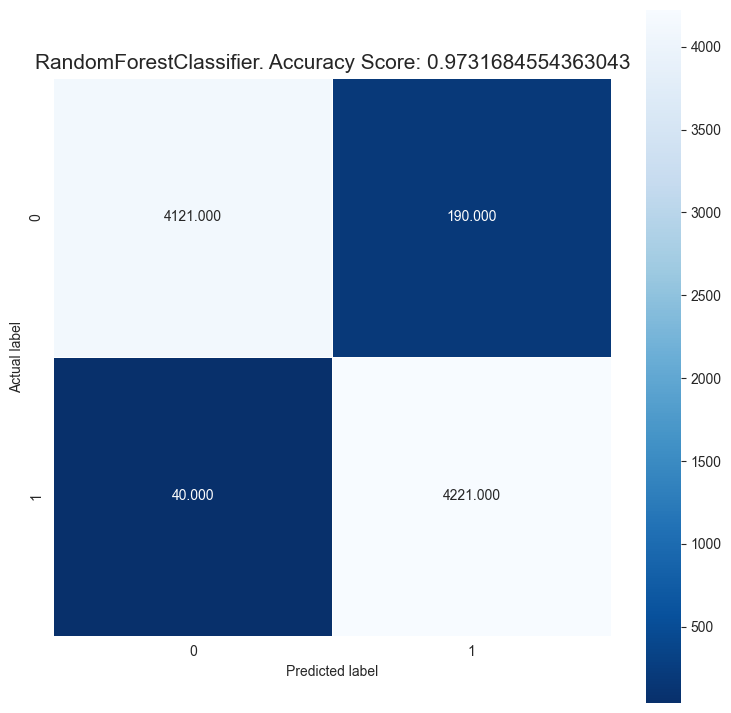

LogisticRegression
>acc=0.919, cfg={'solver': 'newton-cg', 'max_iter': 143.7185929648241, 'C': 0.7143785714285714}
Accuracy: 0.919 


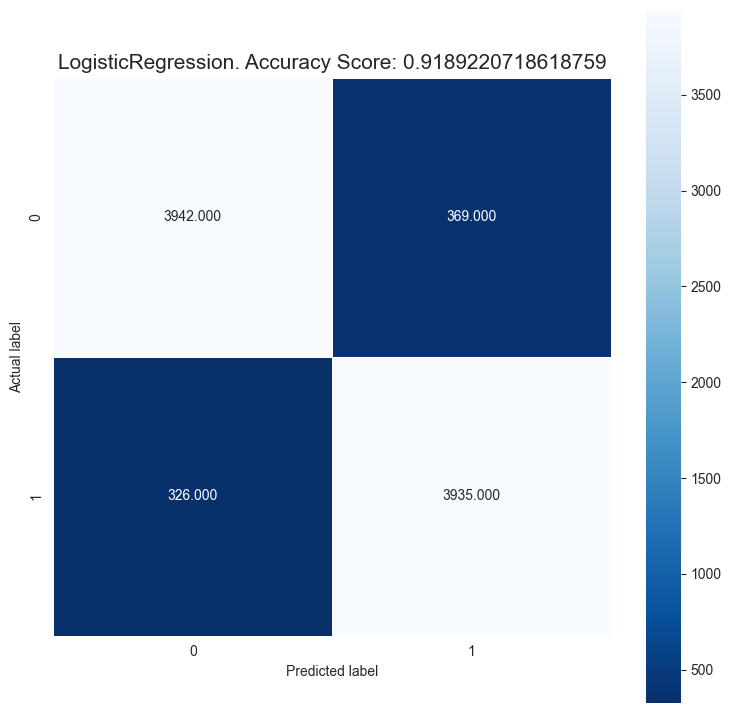

DecisionTreeClassifier
>acc=0.967, cfg={'max_features': 'auto', 'max_depth': 25, 'criterion': 'entropy'}
Accuracy: 0.967 


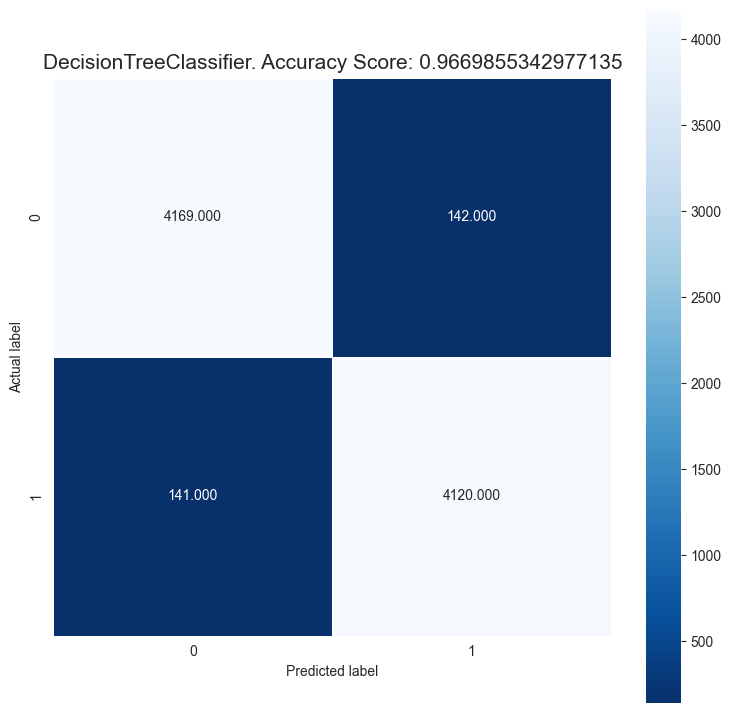

MLPClassifier
>acc=0.971, cfg={'solver': 'lbfgs', 'max_iter': 147, 'hidden_layer_sizes': 136}
Accuracy: 0.971 


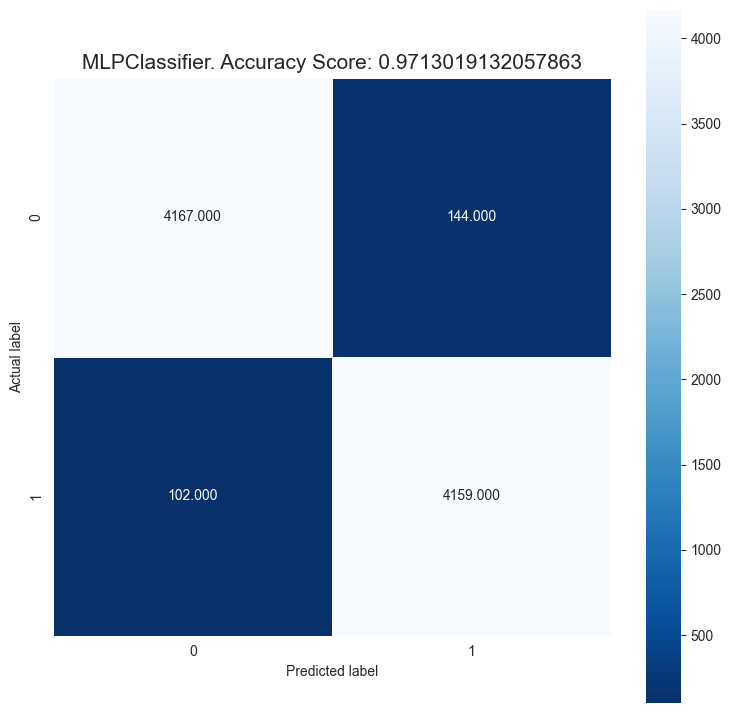

KNeighborsClassifier
>acc=0.973, cfg={'weights': 'distance', 'n_neighbors': 3, 'algorithm': 'auto'}
Accuracy: 0.973 


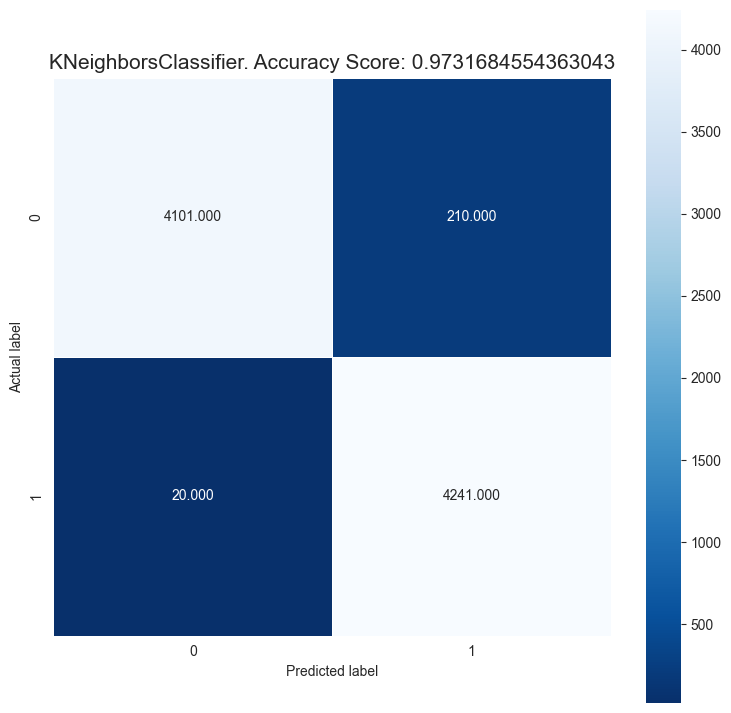

SVC
>acc=0.972, cfg={'kernel': 'rbf', 'C': 6.2315326633165835}
Accuracy: 0.972 


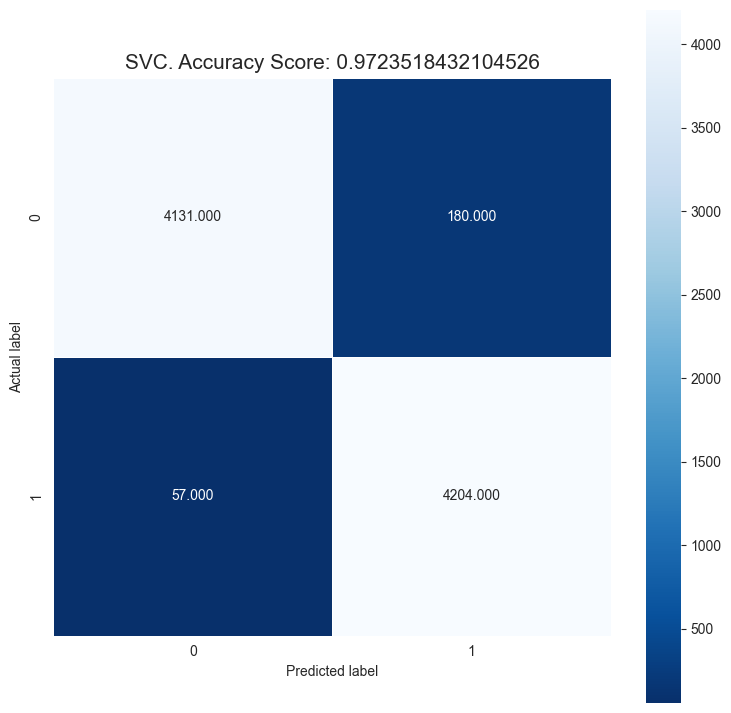

In [45]:
df_report_2 = pd.DataFrame()

df_report_2, rf_acc, rf_model = xval_test(reg_RF, space_rf, df_report_2, df_train, y_train, df_test, y_test)
df_report_2, lr_acc, lr_model = xval_test(reg_lin, space_lr, df_report_2, df_train, y_train, df_test, y_test)
df_report_2, dt_acc, dt_model = xval_test(reg_DT, space_dt, df_report_2, df_train, y_train, df_test, y_test)
df_report_2, mlp_acc, mlp_model = xval_test(reg_MLP, space_mlp, df_report_2, df_train, y_train, df_test, y_test)
df_report_2, kn_acc, kn_model = xval_test(reg_KN, space_kn, df_report_2, df_train, y_train, df_test, y_test)
df_report_2, svc_acc, svc_model = xval_test(reg_SVC, space_svc, df_report_2, df_train, y_train, df_test, y_test)

In [51]:
df_report_2

,Accuracy,F1,Precision,Recall,Balanced Acc,params
RandomForestClassifier,0.973168,0.973478,0.956926,0.990613,0.973270,"{'n_estimators': 7, 'max_features': 12, 'max_d..."
LogisticRegression,0.918922,0.918856,0.914266,0.923492,0.918949,"{'solver': 'newton-cg', 'max_iter': 143.718592..."
DecisionTreeClassifier,0.966986,0.966796,0.966682,0.966909,0.966985,"{'max_features': 'auto', 'max_depth': 25, 'cri..."
MLPClassifier,0.971302,0.971275,0.966535,0.976062,0.971330,"{'solver': 'lbfgs', 'max_iter': 147, 'hidden_l..."
KNeighborsClassifier,0.973168,0.973600,0.952820,0.995306,0.973297,"{'weights': 'distance', 'n_neighbors': 3, 'alg..."
SVC,0.972352,0.972585,0.958942,0.986623,0.972435,"{'kernel': 'rbf', 'C': 6.2315326633165835}"
